# Calculating multichannel collimator transfer function

This ipython notebook will guide through the calculation of the soller slits transfer function. This is a very essential in order to be able to process the data with soller slits. The soller slits have a strong influence on intensity especially for relatively large samples.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Basic Geometry 

In order to calculate the transfer function we need to calculate the opening angle through the slit along the beampath in the sample and integrate all angles. By calculating this for a slit at each 2$\theta$ position we obtain the soller slit transfer function.
<img src="images/sollerslit base geometry1.svg">

To calculate the opening angle through the slit we need to calculate the positions of the points S<sub>1</sub>, S<sub>2</sub> ,Q<sub>1</sub>, Q<sub>2</sub>.
$$\begin{equation}
     S_1=\begin{bmatrix}
             r\cos(2\theta)-\frac{w}{2}\sin(2\theta)\\
             r\sin(2\theta)+\frac{w}{2}\cos(2\theta) \\
         \end{bmatrix} \\
     S_2=\begin{bmatrix}
             r\cos(2\theta)+\frac{w}{2}\sin(2\theta)\\
             r\sin(2\theta)-\frac{w}{2}\cos(2\theta) \\
         \end{bmatrix} \\
     Q_1=\begin{bmatrix}
             (r+b)\cos(2\theta)-\frac{w}{2}\sin(2\theta)\\
             (r+b)\sin(2\theta)+\frac{w}{2}\cos(2\theta) \\
         \end{bmatrix} \\
     Q_2=\begin{bmatrix}
             (r+b)\cos(2\theta)+\frac{w}{2}\sin(2\theta)\\
             (r+b)\sin(2\theta)-\frac{w}{2}\cos(2\theta) \\
         \end{bmatrix}
  \end{equation}
$$
With the help of these points we can calculate the angle from each point along the beam bath which can go through the soller slit. Whereby there exist three different regions: (1) the angle is truncated by Q<sub>1</sub> and Q<sub>2</sub> (e.g. P<sub>1</sub>); (2) the angle is truncated by combination of Q<sub>1</sub> and S<sub>2</sub>, or S<sub>1</sub> and Q<sub>2</sub> (e.g. P<sub>2</sub>); or (3) the diffraction is completely blocked by the multi channel collimator (e.g. P<sub>3</sub>).
<img src="images/sollerslit regions.svg">

### Defining Parameters 

In [5]:
# Parameters in mm:
r = 62 # defines the radius to the slit set
w = 0.05 # the width of one of the slits
b = 8 # length of the slit

### Defining helper functions 

In [6]:
def vector_length(vec):
    return np.sqrt(np.sum(vec**2))

def calculate_angles(point1, point2, p):
    """
    calculates the angle between vectors going from the two points (point1, point2) to a central point p using 
    the dot product.
    """
    return np.arccos(((point1[0]-p[0])*(point2[0]-p[0])+(point1[1]-p[1])*(point2[1]-p[1]))/
                     (np.sqrt((point1[0]-p[0])**2+(point1[1]-p[1])**2)*np.sqrt((point2[0]-p[0])**2+(point2[1]-p[1])**2)))


def calculate_x_axis_intercept(p1, p2):
    """
    obtains the x-axis intercept of a line defined by two points.
    """
    m = p2 - p1
    l = -p2[1]/m[1]
    return l*m[0]+p2[0]

def calculate_y_axis_intercept(p1, p2):
    """
    obtains the y-axis intercept of a line defined by two points.
    """
    m = (p2[1]-p1[1])/(p2[0]-p1[0])
    return m*(-p2[0])+p2[1]

## Dispersion angle $\phi$ that passes through, calculated as a function of 2$\theta$ and of the position along the x-ray beam 

<function __main__.plot_everything>

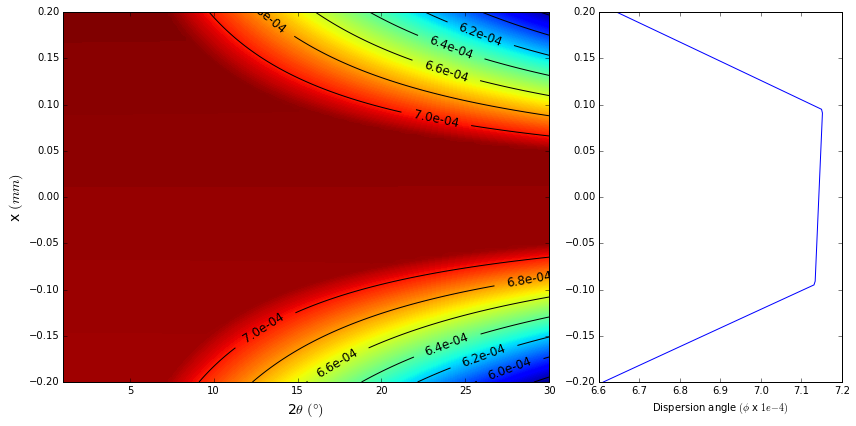

In [8]:
two_theta_array = np.linspace(1, 30, 100)/180.*np.pi
p_x = np.linspace(-0.2, 0.2, 100)
p_y = np.zeros(p_x.shape)
p = np.array([p_x, p_y])
phi_array = []
for two_theta in two_theta_array:
    q1 = np.array([(r+b) * np.cos(two_theta)- 0.5*w*np.sin(two_theta),
                   (r+b) * np.sin(two_theta) +0.5*w*np.cos(two_theta)])

    q2 = np.array([(r+b)*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                   (r+b)*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])
    
    s1 = np.array([r*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                   r*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

    s2 = np.array([r*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                   r*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])

    phi = calculate_angles(q1, q2, p)
    
    #correcting for positive side:
    phi_s2_q1 = calculate_angles(s2, q1, p)
    phi = np.where(phi<phi_s2_q1, phi, phi_s2_q1)
    
    intercept_s2_q1 = calculate_x_axis_intercept(s2, q1)
    phi[p[0]>intercept_s2_q1]=0
    
    #correcting for negative side:
    phi_s1_q2 = calculate_angles(s1, q2, p)
    phi = np.where(phi<phi_s1_q2, phi, phi_s1_q2)
    
    intercept_s1_q2 = calculate_x_axis_intercept(s1, q2)
    phi[p[0]<intercept_s1_q2]=0
    
    phi_array.append(phi)

X, Y = np.meshgrid(two_theta_array/np.pi*180, p[0])
phi_array = np.array(phi_array).transpose()


def plot_everything(line_ind):

    plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
    ax1 = plt.subplot(gs[0])
    plt.contourf(X, Y, phi_array, 200, fontsize=14)
    con = plt.contour(X, Y, phi_array, 8, colors = 'k')
    plt.clabel(con, fmt = '%3.1e', colors = 'k', fontsize=12)
    plt.xlabel("2$\\theta$ $(\degree)$", fontsize=14)
    plt.ylabel("x $(mm)$", fontsize=14)

    ax2 = plt.subplot(gs[1])
    phi = phi_array[:,line_ind]
    plt.plot(phi*1e4, p[0])
    plt.ylim(p[0,0], p[0,-1])
    plt.xlabel("Dispersion angle $(\phi$ x $1e-4)$")

    plt.tight_layout()
    
from ipywidgets import interact

interact(plot_everything, line_ind=(0, 99, 1))

### Dispersion angle $\phi$ that passes through the MCC, calculated as a function of 2$\theta$ and of the position perpendicular to the x-ray beam 

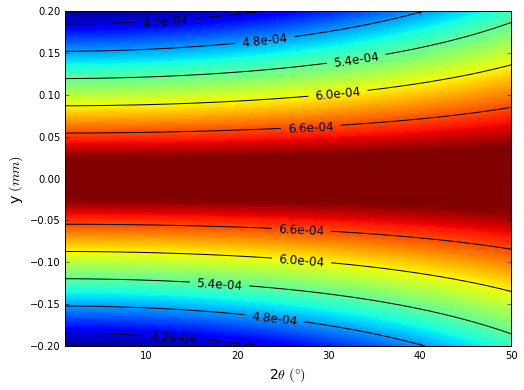

In [5]:
two_theta_array = np.linspace(1, 50)/180.*np.pi
p_y = np.linspace(-0.2, 0.2, 100)
p_x = np.zeros(p_y.shape)
p = np.array([p_x, p_y])
phi_array = []
for two_theta in two_theta_array:
    q1 = np.array([(r+b)*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                   (r+b)*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

    q2 = np.array([(r+b)*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                   (r+b)*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])
    
    s1 = np.array([r*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                   r*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

    s2 = np.array([r*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                   r*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])

    phi = calculate_angles(q1, q2, p)
    
    #correcting for positive side:
    phi_s2_q1 = calculate_angles(s2, q1, p)
    phi = np.where(phi<phi_s2_q1, phi, phi_s2_q1)
    
    y_axis_intercept_s2_q1 = calculate_y_axis_intercept(s2, q1)
    phi[p[1]<y_axis_intercept_s2_q1]=0
    
    #correcting for negative side:
    phi_s1_q2 = calculate_angles(s1, q2, p)
    phi = np.where(phi<phi_s1_q2, phi, phi_s1_q2)
    
    y_axis_intercept_s1_q2 = calculate_y_axis_intercept(s1, q2)
    phi[p[1]>y_axis_intercept_s1_q2]=0
    
    phi_array.append(phi)

X, Y = np.meshgrid(two_theta_array/np.pi*180, p[1])
phi_array = np.array(phi_array).transpose()


plt.figure(figsize=(8, 6))

plt.contourf(X, Y, phi_array, 200)
con = plt.contour(X, Y, phi_array, 5, colors = 'k')
plt.clabel(con, fmt = '%3.1e', colors = 'k', fontsize=12)
plt.xlabel("2$\\theta$ $(\degree)$", fontsize=14)
plt.ylabel("y $(mm)$", fontsize=14)

## Integrated dispersion angle for specific sample thickness -- calculating the transfer function

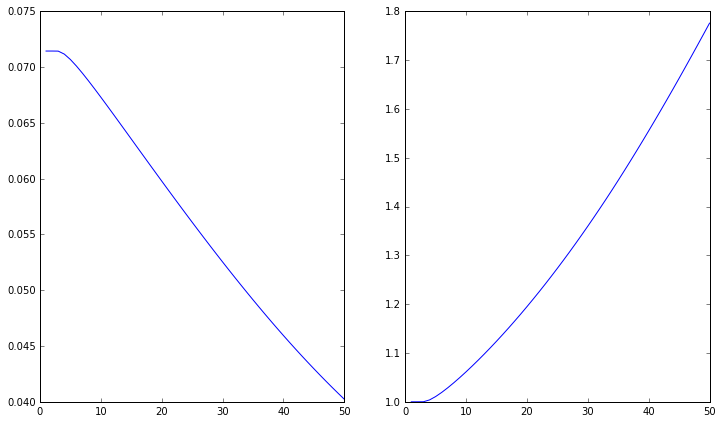

In [44]:
def plot_transfer_function(thickness):
    two_theta_array = np.linspace(1, 50)/180.*np.pi
    transfer_function = []
    p_x = np.linspace(-thickness/2., thickness/2., 100)
    p_y = np.zeros(p_x.shape)
    p = np.array([p_x, p_y])
    for two_theta in two_theta_array:
        q1 = np.array([(r+b)*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                       (r+b)*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

        q2 = np.array([(r+b)*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                       (r+b)*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])

        s1 = np.array([r*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                       r*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

        s2 = np.array([r*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                       r*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])

        phi = calculate_angles(q1, q2, p)

         #correcting for positive side:
        phi_s2_q1 = calculate_angles(s2, q1, p)
        phi = np.where(phi<phi_s2_q1, phi, phi_s2_q1)

        intercept_s2_q1 = calculate_x_axis_intercept(s2, q1)
        phi[p[0]>intercept_s2_q1]=0

        #correcting for negative side:
        phi_s1_q2 = calculate_angles(s1, q2, p)
        phi = np.where(phi<phi_s1_q2, phi, phi_s1_q2)

        intercept_s1_q2 = calculate_x_axis_intercept(s1, q2)
        phi[p[0]<intercept_s1_q2]=0

        transfer_function.append(np.sum(phi))
        
    plt.figure(figsize=(12,7))
    plt.subplot(1, 2, 1)
    plt.plot(two_theta_array*180/np.pi, transfer_function)
   
    plt.subplot(1, 2, 2) 
    inverse_transfer_function = 1./np.array(transfer_function)
    normalized_inverse_transfer_function = inverse_transfer_function/inverse_transfer_function[0]
    plt.plot(two_theta_array*180/np.pi, normalized_inverse_transfer_function)
    
#from ipywidgets import interact
#interact(plot_transfer_function, thickness=(0, 2, 0.01))

plot_transfer_function(1)

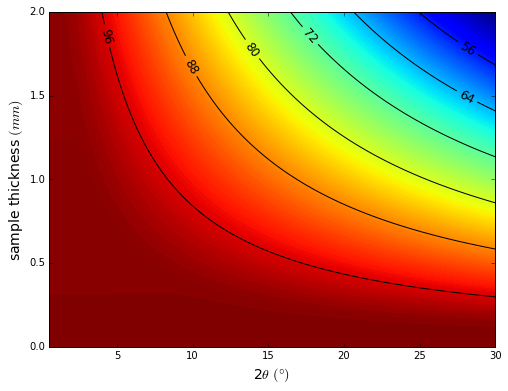

In [52]:
thickness_array = np.linspace(0, 2, 100)
two_theta_array = np.linspace(0.5, 30)/180.*np.pi

output = []

for thickness in thickness_array:
    p_x = np.linspace(-thickness/2., thickness/22., 100)
    p_y = np.zeros(p_x.shape)
    p = np.array([p_x, p_y])
    transfer_function = []
    for two_theta in two_theta_array:
        q1 = np.array([(r+b)*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                       (r+b)*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

        q2 = np.array([(r+b)*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                       (r+b)*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])

        s1 = np.array([r*np.cos(two_theta)-0.5*w*np.sin(two_theta),
                       r*np.sin(two_theta)+0.5*w*np.cos(two_theta)])

        s2 = np.array([r*np.cos(two_theta) + 0.5 *w*np.sin(two_theta),
                       r*np.sin(two_theta) - 0.5 *w*np.cos(two_theta)])

        phi = calculate_angles(q1, q2, p)

         #correcting for positive side:
        phi_s2_q1 = calculate_angles(s2, q1, p)
        phi = np.where(phi<phi_s2_q1, phi, phi_s2_q1)

        intercept_s2_q1 = calculate_x_axis_intercept(s2, q1)
        phi[p[0]>intercept_s2_q1]=0

        #correcting for negative side:
        phi_s1_q2 = calculate_angles(s1, q2, p)
        phi = np.where(phi<phi_s1_q2, phi, phi_s1_q2)

        intercept_s1_q2 = calculate_x_axis_intercept(s1, q2)
        phi[p[0]<intercept_s1_q2]=0

        #adding up all angles to get a notion of how large the contribution will be for this twotheta value
        transfer_function.append(np.sum(phi))
    output.append(transfer_function)

    
#normalize 
output = np.array(output)
output = output/np.max(output)*100

X, Y = np.meshgrid(two_theta_array/np.pi*180, thickness_array)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, output, 200)
con = plt.contour(X, Y, output,  colors = 'k')
plt.clabel(con, fmt = '%2.0f', colors = 'k', fontsize=12)
plt.xlabel("2$\\theta$ $(\degree)$", fontsize=14)
plt.ylabel("sample thickness $(mm)$", fontsize=14)

## With both slits as parameters:

In [77]:
# Parameters in mm:
r1 = 62 # defines the radius to the inner slit set
r2 = 210 # defines the radius to the outer slit set
w1 = 0.025 # the width of one of the inner slits
w2 = 0.1 # the width of one of the outer slits
b1 = 8 # length of the inner slits
b2 = 6 # length of the outer slits

<function __main__.plot_everything>

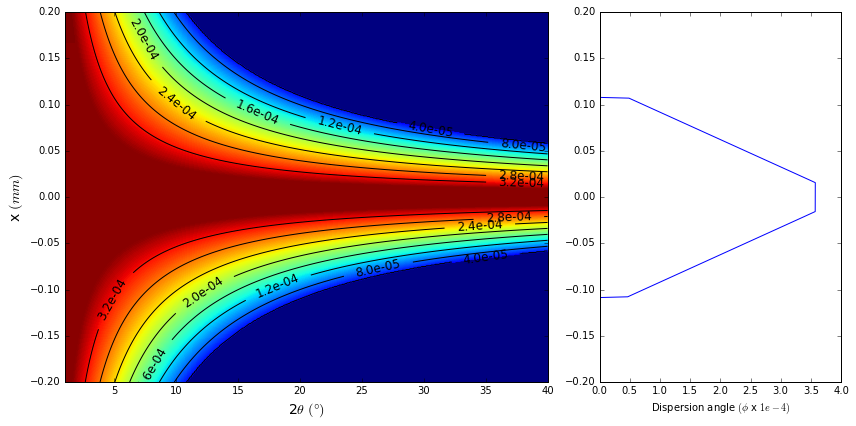

In [78]:
two_theta_array = np.linspace(1, 40, 500)/180.*np.pi
p_x = np.linspace(-0.2, 0.2, 500)
p_y = np.zeros(p_x.shape)
p = np.array([p_x, p_y])
phi_array = []
for two_theta in two_theta_array:
    #calculate fix points for the ther outer parts of the slits
    q1_1 = np.array([(r1+b1) * np.cos(two_theta)- 0.5*w1*np.sin(two_theta),
                   (r1+b1) * np.sin(two_theta) +0.5*w1*np.cos(two_theta)])

    q1_2 = np.array([(r1+b1)*np.cos(two_theta) + 0.5 *w1*np.sin(two_theta),
                   (r1+b1)*np.sin(two_theta) - 0.5 *w1*np.cos(two_theta)])
    
    q2_1 = np.array([(r2+b2) * np.cos(two_theta)- 0.5*w2*np.sin(two_theta),
                   (r2+b2) * np.sin(two_theta) +0.5*w2*np.cos(two_theta)])

    q2_2 = np.array([(r2+b2)*np.cos(two_theta) + 0.5 *w2*np.sin(two_theta),
                   (r2+b2)*np.sin(two_theta) - 0.5 *w2*np.cos(two_theta)])
    
    
    # calculate fix points for the inner parts of the slits
    s1_1 = np.array([r1*np.cos(two_theta)-0.5*w1*np.sin(two_theta),
                   r1*np.sin(two_theta)+0.5*w1*np.cos(two_theta)])

    s1_2 = np.array([r1*np.cos(two_theta) + 0.5 *w1*np.sin(two_theta),
                   r1*np.sin(two_theta) - 0.5 *w1*np.cos(two_theta)])
    
    s2_1 = np.array([r2*np.cos(two_theta)-0.5*w2*np.sin(two_theta),
                   r2*np.sin(two_theta)+0.5*w2*np.cos(two_theta)])

    s2_2 = np.array([r2*np.cos(two_theta) + 0.5 *w2*np.sin(two_theta),
                   r2*np.sin(two_theta) - 0.5 *w2*np.cos(two_theta)])
    
    
    intercept_q1_1_q2_1 = calculate_x_axis_intercept(q1_1, q2_1)
    intercept_q1_2_q2_2 = calculate_x_axis_intercept(q1_2, q2_2)
    
    

    #calculate the angles to the outer points of the slits
    phi1 = calculate_angles(q1_1, q1_2, p)
    phi2 = calculate_angles(q2_1, q2_2, p)
    phi3 = calculate_angles(q2_1, q1_2, p)
    phi4 = calculate_angles(q1_1, q2_2, p)
    
    #take the smallest angle for each point
    phi = np.where(phi1<phi2, phi1, phi2)
    phi = np.where(phi3<phi, phi3, phi)
    phi = np.where(phi4<phi, phi4, phi)
    
    #correcting for positive side:
    phi_s1_2_q1_1 = calculate_angles(s1_2, q1_1, p)
    phi = np.where(phi<phi_s1_2_q1_1, phi, phi_s1_2_q1_1)
    
    intercept_s1_2_q1_1 = calculate_x_axis_intercept(s1_2, q1_1)
    phi[p[0]>intercept_s1_2_q1_1]=0
    
    intercept_s1_2_q2_1 = calculate_x_axis_intercept(s1_2, q2_1)
    phi[p[0]>intercept_s1_2_q2_1]=0
    
    #correcting for negative side:
    phi_s1_1_q1_2 = calculate_angles(s1_1, q1_2, p)
    phi = np.where(phi<phi_s1_1_q1_2, phi, phi_s1_1_q1_2)
    
    intercept_s1_1_q1_2 = calculate_x_axis_intercept(s1_1, q1_2)
    phi[p[0]<intercept_s1_1_q1_2]=0
    
    intercept_s1_1_q2_2 = calculate_x_axis_intercept(s1_1, q2_2)
    phi[p[0]<intercept_s1_1_q2_2]=0
    
    phi_array.append(phi)

X, Y = np.meshgrid(two_theta_array/np.pi*180, p[0])
phi_array = np.array(phi_array).transpose()



def plot_everything(line_ind):

    plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
    ax1 = plt.subplot(gs[0])
    plt.contourf(X, Y, phi_array, 200, fontsize=14)
    con = plt.contour(X, Y, phi_array, 8, colors = 'k')
    plt.clabel(con, fmt = '%3.1e', colors = 'k', fontsize=12)
    plt.xlabel("2$\\theta$ $(\degree)$", fontsize=14)
    plt.ylabel("x $(mm)$", fontsize=14)

    ax2 = plt.subplot(gs[1])
    phi = phi_array[:,line_ind]
    plt.plot(phi*1e4, p[0])
    plt.ylim(p[0,0], p[0,-1])
    plt.xlabel("Dispersion angle $(\phi$ x $1e-4)$")

    plt.tight_layout()
    
from ipywidgets import interact

interact(plot_everything, line_ind=(0, 499, 1))

/home/clemens/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in arccos
/home/clemens/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in less
/home/clemens/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in less
/home/clemens/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less


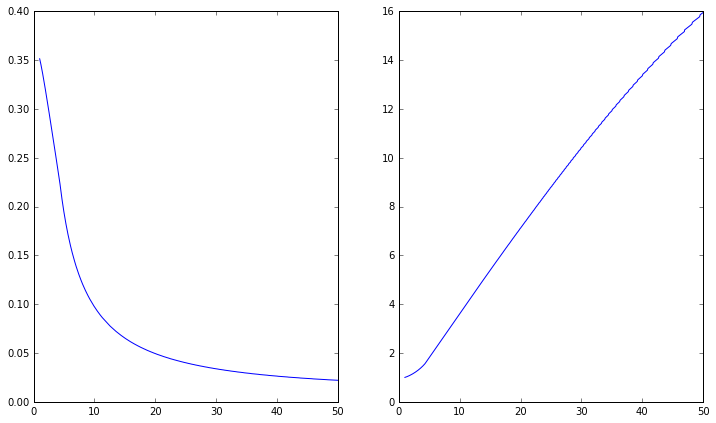

In [86]:
def plot_transfer_function(thickness):
    two_theta_array = np.linspace(1, 50, 1000)/180.*np.pi
    transfer_function = []
    p_x = np.linspace(-thickness/2., thickness/2., 1000)
    p_y = np.zeros(p_x.shape)
    p = np.array([p_x, p_y])
    for two_theta in two_theta_array:
        #calculate fix points for the ther outer parts of the slits
        q1_1 = np.array([(r1+b1) * np.cos(two_theta)- 0.5*w1*np.sin(two_theta),
                       (r1+b1) * np.sin(two_theta) +0.5*w1*np.cos(two_theta)])

        q1_2 = np.array([(r1+b1)*np.cos(two_theta) + 0.5 *w1*np.sin(two_theta),
                       (r1+b1)*np.sin(two_theta) - 0.5 *w1*np.cos(two_theta)])

        q2_1 = np.array([(r2+b2) * np.cos(two_theta)- 0.5*w2*np.sin(two_theta),
                       (r2+b2) * np.sin(two_theta) +0.5*w2*np.cos(two_theta)])

        q2_2 = np.array([(r2+b2)*np.cos(two_theta) + 0.5 *w2*np.sin(two_theta),
                       (r2+b2)*np.sin(two_theta) - 0.5 *w2*np.cos(two_theta)])


        # calculate fix points for the inner parts of the slits
        s1_1 = np.array([r1*np.cos(two_theta)-0.5*w1*np.sin(two_theta),
                       r1*np.sin(two_theta)+0.5*w1*np.cos(two_theta)])

        s1_2 = np.array([r1*np.cos(two_theta) + 0.5 *w1*np.sin(two_theta),
                       r1*np.sin(two_theta) - 0.5 *w1*np.cos(two_theta)])

        s2_1 = np.array([r2*np.cos(two_theta)-0.5*w2*np.sin(two_theta),
                       r2*np.sin(two_theta)+0.5*w2*np.cos(two_theta)])

        s2_2 = np.array([r2*np.cos(two_theta) + 0.5 *w2*np.sin(two_theta),
                       r2*np.sin(two_theta) - 0.5 *w2*np.cos(two_theta)])


        #calculate the angles to the outer points of the slit
        phi1 = calculate_angles(q1_1, q1_2, p)
        phi2 = calculate_angles(q2_1, q2_2, p)
        phi3 = calculate_angles(q2_1, q1_2, p)
        phi4 = calculate_angles(q1_1, q2_2, p)

        #take the smallest angle from both
        phi = np.where(phi1<phi2, phi1, phi2)
        phi = np.where(phi3<phi, phi3, phi)
        phi = np.where(phi4<phi, phi4, phi)

        #correcting for positive side:
        phi_s1_2_q1_1 = calculate_angles(s1_2, q1_1, p)
        phi = np.where(phi<phi_s1_2_q1_1, phi, phi_s1_2_q1_1)

        intercept_s1_2_q1_1 = calculate_x_axis_intercept(s1_2, q1_1)
        phi[p[0]>intercept_s1_2_q1_1]=0

        intercept_s1_2_q2_1 = calculate_x_axis_intercept(s1_2, q2_1)
        phi[p[0]>intercept_s1_2_q2_1]=0

        #correcting for negative side:
        phi_s1_1_q1_2 = calculate_angles(s1_1, q1_2, p)
        phi = np.where(phi<phi_s1_1_q1_2, phi, phi_s1_1_q1_2)

        intercept_s1_1_q1_2 = calculate_x_axis_intercept(s1_1, q1_2)
        phi[p[0]<intercept_s1_1_q1_2]=0

        intercept_s1_1_q2_2 = calculate_x_axis_intercept(s1_1, q2_2)
        phi[p[0]<intercept_s1_1_q2_2]=0

        transfer_function.append(np.sum(phi))
        
    plt.figure(figsize=(12,7))
    plt.subplot(1, 2, 1)
    plt.plot(two_theta_array*180/np.pi, transfer_function)
   
    plt.subplot(1, 2, 2) 
    inverse_transfer_function = 1./np.array(transfer_function)
    normalized_inverse_transfer_function = inverse_transfer_function/inverse_transfer_function[0]
    plt.plot(two_theta_array*180/np.pi, normalized_inverse_transfer_function)
    
#from ipywidgets import interact
#interact(plot_transfer_function, thickness=(0, 2, 0.01))

plot_transfer_function(01)